# Data: Moscow region

Официальным источником данных по заболеваемости является сайт министерства здравоохранения Московской области посвящённой эпидемии COVID-19 https://covid.mz.mosreg.ru/
Однако, сайт достаточно неудобен для сбора данных с указанием дат, поэтому данные извлекались с сайта подмосковного СМИ https://radio1.news/, которое выполняло оперативное распостранение данных с указанием дат.

In [1]:
import urllib
import re
import pickle as pkl
import numpy as np
from tqdm import tqdm
import requests
from urllib.request import urlopen
from lxml import etree
import string
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%config Copleter.use_jedi = False

### HTML pages dowloading

In [3]:
url_path = 'https://radio1.news/article/raspredelenie-zabolevshih-koronavirusom-v-gorodah-moskovskoj-oblasti-40088'

d = {}
for i in tqdm(range(39000, 54000)):
    new_url = url_path[:-5] + '%d' % i
    url = urllib.request.urlopen(new_url)
    webContent = url.read()
    d[i] = webContent

100%|██████████| 15000/15000 [22:24<00:00, 11.16it/s]  


### HTML pages parsing

In [28]:
def date_extraction(tr):
    '''Extract HTML creation date'''
    date = tree.xpath('//body//div[contains(@class, "a-tools--date")]//text()')[0]
    for i in replace_dict:
        if i in date:
            date = date.replace(i, replace_dict[i])
#     dates += [sum(map(int, date.split()[:2]))]
    return sum(map(int, date.split()[:2]))

def news_text_processing(content_string):
    '''Cut part before cities enumeration clean all punctuation and split by space'''
    content_string = content_string[content_string.find(':'):]
    content_string = re.sub('[()].*[)]', '', content_string)
    content_string = content_string.translate(str.maketrans('', '', pnkt))
    content_string = content_string.replace('\xa0', ' ').replace('\xad', ' ')
    return [i for i in content_string.replace('\n', ' ').split(' ') if i]

def city_numbers_extractions(content_parts):
    '''Extract first nubmer after city name appearance and this function need more attantion if there are cities without numbers'''
    t_d = {k: 0 for k in cities_names}
    for n, word in enumerate(content_parts[:-1]):
        if word in cities_names and not t_d[word]:
            if content_parts[n+1].isdigit():
                t_d[word] = int(content_parts[n+1])
            else:
                raise 'problems with string and city name:\n%s\n%s' % (word, content_string)
    return t_d 
    

def page_parse(tree):
    # news content extraction
    content = tree.xpath('//body//div[contains(@class, "richtext--text")]//text()')
    content = [str(s).lower().replace('ё', 'е') for s in content]
    content_string = '\n'.join(content)
    # news with selection pages with sought statistic
    if all([i in content_string for i in key_words]):
        data = [date_extraction(tree)]
        try:
            t_d = city_numbers_extractions(news_text_processing(content_string))
        except:
            return None
        return [tree.xpath('//body//h1//text()')[0]] + data + [t_d[k] for k in cities_names]
    else:
        return None

##### some global variables for page parsing

In [25]:
pnkt = string.punctuation + '–'
htmlparser = etree.HTMLParser()

# Target words for selection pages with sought statistic
key_words = ['Химки', "Красногорск", 'корона', 'случ', 'забол', 'Одинцово', 'Подольск', 'Люберцы', 'Балашиха']
key_words = [s.lower() for s in key_words]

# Target cities
cities_names = ['Химки', "Красногорск", 'Одинцово', 'Домодедово', 'Подольск', 'Люберцы', 'Балашиха',
             'Мытищи', 'Щелково']
cities_names = [s.lower() for s in cities_names]

# For conversion date to day number
mounths = ['марта','апреля','мая','июня','июля','августа','сентября','октября','ноября','декабря']
start_days = ['60','91','121','152','182','213','244','274','305','335']
replace_dict = dict(zip(mounths, start_days))


Немного об организации хранения данных, будем хранить их в порядке упомянутом ранее в списке городов, кроме того будет сохранять так же заголовок новости в которой была дана информация, а так же ссылку на данную новость, и дату её публикации, которую будем также считать датой для которой данные актуальны, дата переводится в формат порядковых номеров дней года, например 1 марта = 60.

Полный порядок: заголовок / ссылка / дата / данные

In [29]:
all_data = []
for i in tqdm(d):
    tree = etree.fromstring(d[i].decode("utf-8", "strict"), htmlparser)
    result = page_parse(tree)
    if result is not None:
        all_data += [[url_path[:-5] + '%d' % i] + result]


 25%|██▍       | 3688/15000 [00:15<00:40, 280.05it/s]


 52%|█████▏    | 7838/15000 [00:30<00:27, 257.05it/s]


 78%|███████▊  | 11694/15000 [00:44<00:12, 266.76it/s]


100%|██████████| 15000/15000 [00:57<00:00, 262.25it/s]


##### data point example

In [30]:
all_data[0]

['https://radio1.news/article/raspredelenie-zabolevshih-koronavirusom-v-gorodah-moskovskoj-oblasti-40088',
 'Распределение заболевших коронавирусом в городах Московской области',
 88,
 4,
 6,
 12,
 1,
 2,
 3,
 3,
 3,
 1]

##### create dictionary to convert in csv format

In [39]:
column_titles = ['url', 'page_title', 'date'] + cities_names
main_data_dict = {i:[] for i in column_titles}
for data_unit in  all_data:
    for n, i in enumerate(column_titles):
        main_data_dict[i] += [data_unit[n]]

##### check graph

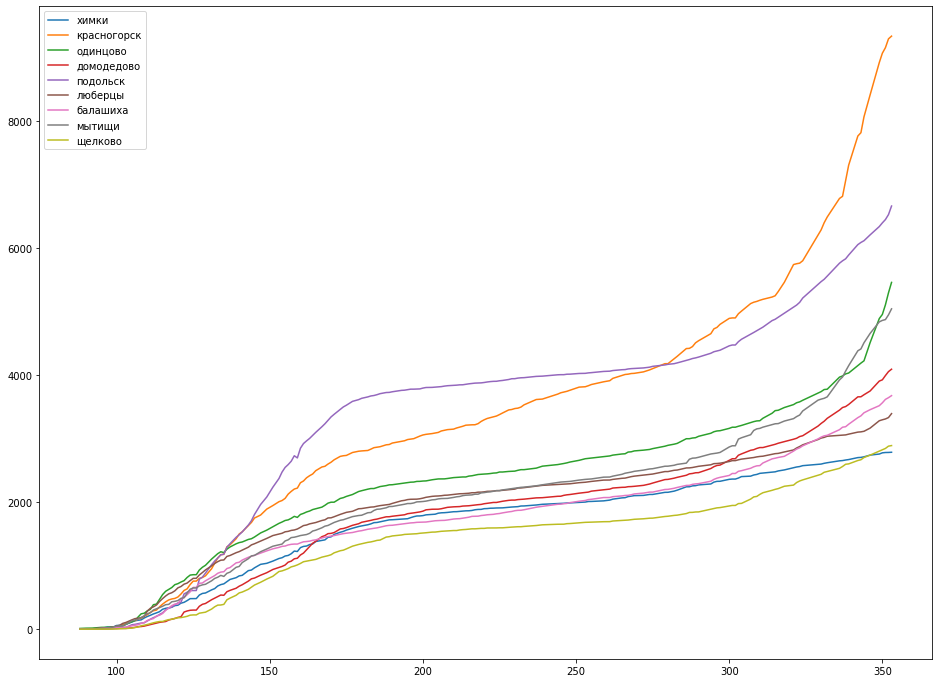

In [36]:
plt.figure(figsize=(16,12))
for i in  cities_names:
    plt.plot(dates, main_data_dict[i], label=i)
plt.legend()
plt.show()

##### save data in csv

In [38]:
pd.DataFrame.from_dict(main_data_dict).to_csv('mos_obl_data.csv', index=False, encoding='utf-8')

# Data: Moscow

Данные по Москве достать существенно проще, можно скачать уже подготовленный датасет с ресурса datalens.yandex, единственно, нужно привести привести столбец даты в соответсвие с ранее выбранным форматом порядкового номера дня

In [41]:
yandex_data_name = 'DataExport_2020-12-06_06-59.csv'
mos_data = pd.read_csv(yandex_data_name, encoding='utf-8')
mos_data

,Дата,Заражений
0,12.03.2020,21
1,13.03.2020,26
2,14.03.2020,35
3,15.03.2020,35
4,16.03.2020,53
...,...,...
264,01.12.2020,612248
265,02.12.2020,617439
266,03.12.2020,625189
267,04.12.2020,632057


In [43]:
mos_data['date'] = list(range(72,72+mos_data.shape[0]))

In [44]:
mos_data.to_csv('mos_data.csv', index=False, encoding='utf-8')